## Movies Dataset

In [1]:
import requests
import json
import time
import tqdm
import csv
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles

### Setup IMDB

In [4]:
with open('secrets.json') as f:
    secrets = json.load(f)

In [11]:
import requests

url = f"https://api.themoviedb.org/3/discover/movie?include_adult=true&include_video=false&language=en-US&page=1&sort_by=popularity.desc"

headers = {
    "accept": "application/json",
    "Authorization": f"Bearer {secrets['tmdb-secret']}"
}

response = requests.get(url, headers=headers)

print(response.text)

data = response.json()
print(len(data['results']))
print(data['total_results'])
print(len(response.text))
print(12885*data['total_pages'])
46745*3.2
# ~41min for all data

{"page":1,"results":[{"adult":false,"backdrop_path":"/4woSOUD0equAYzvwhWBHIJDCM88.jpg","genre_ids":[28,27,53],"id":1096197,"original_language":"en","original_title":"No Way Up","overview":"Characters from different backgrounds are thrown together when the plane they're travelling on crashes into the Pacific Ocean. A nightmare fight for survival ensues with the air supply running out and dangers creeping in from all sides.","popularity":2853.409,"poster_path":"/hu40Uxp9WtpL34jv3zyWLb5zEVY.jpg","release_date":"2024-01-18","title":"No Way Up","video":false,"vote_average":5.662,"vote_count":65},{"adult":false,"backdrop_path":"/oBIQDKcqNxKckjugtmzpIIOgoc4.jpg","genre_ids":[28,53,10752],"id":969492,"original_language":"en","original_title":"Land of Bad","overview":"When a Delta Force special ops mission goes terribly wrong, Air Force drone pilot Reaper has 48 hours to remedy what has devolved into a wild rescue operation. With no weapons and no communication other than the drone above, the g

149584.0

### Get the Genres

In [5]:
url = "https://api.themoviedb.org/3/genre/movie/list?language=en"

headers = {
    "accept": "application/json",
    "Authorization": f"Bearer {secrets['tmdb-secret']}"
}

response = requests.get(url, headers=headers)
data = response.json()
print(data)

genres_map = { genre['id']: genre['name'] for genre in data['genres'] }

print(genres_map)
keep_genres = [ 'Action', 'Comedy', 'Horror' ]

{'genres': [{'id': 28, 'name': 'Action'}, {'id': 12, 'name': 'Adventure'}, {'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 80, 'name': 'Crime'}, {'id': 99, 'name': 'Documentary'}, {'id': 18, 'name': 'Drama'}, {'id': 10751, 'name': 'Family'}, {'id': 14, 'name': 'Fantasy'}, {'id': 36, 'name': 'History'}, {'id': 27, 'name': 'Horror'}, {'id': 10402, 'name': 'Music'}, {'id': 9648, 'name': 'Mystery'}, {'id': 10749, 'name': 'Romance'}, {'id': 878, 'name': 'Science Fiction'}, {'id': 10770, 'name': 'TV Movie'}, {'id': 53, 'name': 'Thriller'}, {'id': 10752, 'name': 'War'}, {'id': 37, 'name': 'Western'}]}
{28: 'Action', 12: 'Adventure', 16: 'Animation', 35: 'Comedy', 80: 'Crime', 99: 'Documentary', 18: 'Drama', 10751: 'Family', 14: 'Fantasy', 36: 'History', 27: 'Horror', 10402: 'Music', 9648: 'Mystery', 10749: 'Romance', 878: 'Science Fiction', 10770: 'TV Movie', 53: 'Thriller', 10752: 'War', 37: 'Western'}


### Download data

In [23]:
jl = open('movies.jsonl', 'w')

n_pages = 46745
# also the checkpoint
p = 1
pbar = tqdm.tqdm(total=n_pages)
while p <= n_pages+1:
    url = f"https://api.themoviedb.org/3/discover/movie?include_adult=true&include_video=false&language=en-US&page={p}&sort_by=popularity.desc"
    response = requests.get(url, headers=headers)

    if response.status_code == 200:
        data = response.json()
        for movie in data['results']:
            jl.write(f"{json.dumps(movie)}\n")
        p+=1
        pbar.update(1)
    else:
        print(f"page: {p}; failed: {response.status_code}...")
        time.sleep(60)

jl.close()

  0%|          | 41/46745 [00:10<3:13:53,  4.01it/s]


page: 501; failed: 400...


KeyboardInterrupt: 

In [24]:
url = f"https://api.themoviedb.org/3/discover/movie?include_adult=true&include_video=false&language=en-US&page=501&sort_by=popularity.desc"

headers = {
    "accept": "application/json",
    "Authorization": f"Bearer {secrets['tmdb-secret']}"
}

response = requests.get(url, headers=headers)

print(response.text)

{"success":false,"status_code":22,"status_message":"Invalid page: Pages start at 1 and max at 500. They are expected to be an integer."}


In [ ]:
import requests

url = "https://api.themoviedb.org/3/discover/movie?include_adult=true&include_video=false&language=en-US&page=1&sort_by=popularity.desc&with_genres=28&without_genres=10%2C1"

headers = {
    "accept": "application/json",
    "Authorization": f"Bearer {secrets['tmdb-secret']}"
}

response = requests.get(url, headers=headers)

print(response.text)

### Overkill

In [ ]:
jl = open('movies-all.jsonl', 'w')

n_pages = 500 # cant do more
# also the checkpoint
for i, g in enumerate(genres_map.keys()):
    p = 1
    pbar = tqdm.tqdm(total=n_pages)
    pbar.reset(total=n_pages)
    total_pages = 0
    without_genres = '%2C'.join([ str(k) for k in list(genres_map.keys())[:i] ])
    pbar.set_description(f"genre: {g}; without: {without_genres}")
    while p <= n_pages:
        url = f"https://api.themoviedb.org/3/discover/movie?include_adult=true&include_video=false&language=en-US&page={p}&sort_by=popularity.desc&with_genres={g}&without_genres={without_genres}"
        response = requests.get(url, headers=headers)

        if response.status_code == 200:
            data = response.json()
            total_pages = data['total_pages']
            for movie in data['results']:
                jl.write(f"{json.dumps(movie)}\n")
            p+=1
            pbar.update(1)
        else:
            print(f"page: {p}; failed: {response.status_code}; {response.text}...")
            time.sleep(60)
    print(p, total_pages)
jl.close()

In [95]:
# could try a yield with this
# boring but fine
# iter tools is hard, just use a mask
with_combs_mask = []
for i in range(2**len(genres_map)):
    mask = format(i, f'#0{len(genres_map)+2}b')[2:]
    with_combs_mask.append(mask)

# dont store the actual list, it will be a big list of lists
print(len(with_combs_mask))
print(with_combs_mask[:5])

524288
['0000000000000000000', '0000000000000000001', '0000000000000000010', '0000000000000000011', '0000000000000000100']


In [61]:
import requests

p = '195'
g = '878'
without_genres = "28%2C12%2C16%2C35%2C80%2C99%2C18%2C10751%2C14%2C36%2C27%2C10402%2C9648%2C10749"

url = f"https://api.themoviedb.org/3/discover/movie?include_adult=true&include_video=false&language=en-US&page={p}&sort_by=popularity.desc&with_genres={g}&without_genres={without_genres}"

headers = {
    "accept": "application/json",
    "Authorization": f"Bearer {secrets['tmdb-secret']}"
}

response = requests.get(url, headers=headers)

print(response.text)

{"page":195,"results":[],"total_pages":194,"total_results":3870}


In [115]:
import tqdm
import requests

jl = open('movies-all-all.jsonl', 'w')

# we dont care about 0
pbar = tqdm.tqdm(with_combs_mask[1:])
all_pages = []
for i, mask in enumerate(pbar):
    total_pages = 0

    # this is right
    # convert the mask to the search query
    keys = list(genres_map.keys())
    with_genres    = '%2C'.join([ str(keys[j]) for j, m in enumerate(mask) if m == '1' ])
    without_genres = '%2C'.join([ str(keys[j]) for j, m in enumerate(mask) if m == '0' ])

    # keep searching this query
    p = 1
    movies = []
    while True:
        pbar.set_description(f"pages: {p} / {pages}; movies: {len(movies)}")

        # download the data
        url = f"https://api.themoviedb.org/3/discover/movie?include_adult=true&include_video=false&language=en-US&page={p}&sort_by=popularity.desc&with_genres={with_genres}&without_genres={without_genres}"
        response = requests.get(url, headers=headers)
        data = response.json()
        pages = data['total_pages']

        if p == 1:
            all_pages.append({'i': i, 'pages': pages})

        movies = data['results']
        # we have no more pages to search
        if len(movies) == 0:
            break

        # get the movies and store them
        for movie in movies:
            jl.write(f"{json.dumps(movie)}\n")
        p+=1

jl.close()

pages: 501 / 854; movies: 20:   0%|          | 127/524287 [09:19<641:16:11,  4.40s/it]


KeyError: 'total_pages'

### Look for Dupes

In [74]:
# i could ttry every combinattion
# only show movies, so the empty results done matter
# this is list of movies
# maybe i couldve made this a dict, and look for key errors
# not in array (append obj): 16m 20.0s
# in array:                  should be the same (if no dupes)
# in array:                  32.4s
#        only 5 dupes not bad. when cmp obj, they had different scores, so different.
#        thought this would work, but whatever
# in dict:  0.8s
#        prolly could have only one dict now
uniques = {}
dupes = {}
with open('movies-all.jsonl') as f:
    for line in tqdm.tqdm(f, total=131282):
        movie = json.loads(line)
        movie_id = movie['id']
        # in is more efficient
        if movie_id in uniques:
            if movie_id in dupes:
                dupes[movie_id] += 1
            else:
                dupes[movie_id] = 1
        else:
            # just a ph or something
            uniques[movie_id] = 0

print(len(uniques))
print(dupes)

100%|██████████| 131282/131282 [00:00<00:00, 148534.12it/s]

131276
{427641: 1, 811634: 1, 1924: 1, 81188: 1, 1027073: 1, 97020: 1}


In [ ]:
objs = []
with open('movies-all.jsonl') as f:
    for line in tqdm.tqdm(f, total=131282):
        movie = json.loads(line)
        movie_id = movie['id']
        
        if movie_id in dupes.keys():
            objs.append(movie)

# sort objs by id
objs = sorted(objs, key=lambda x: x['id'])
for obj in objs:
    print(f"{obj['id']}\t{obj}")

### Harvest Data
since i know how this works. i can skip some steps<br>
also. this is **big** data, so im going to stick with streaming

In [6]:
def conv(mask):
    return format(mask, f'#0{len(keep_genres)+2}b')[2:]

# dont do zero
# should be l!, but this is fine
total = 0
sizes = { conv(i): 0 for i in range(0, 2**len(keep_genres)) }

f_movies = open('movies-all.csv', 'w')
csv_writer = csv.writer(f_movies)
csv_writer.writerow(['adult', 'title', *genres_map, 'description'])

total = 0
counts = { genres_map[genre]: 0 for genre in genres_map.keys() }
with open('movies-all.jsonl') as f:
    for line in f:
        obj = json.loads(line)
        genres = []
        kept_genres = []
        for genre in genres_map:
            if genre in obj['genre_ids']:
                genres.append(True)
                counts[genres_map[genre]] += 1
                if genres_map[genre] in keep_genres:
                    kept_genres.append(True)
            else:
                genres.append(False)
                if genres_map[genre] in keep_genres:
                    kept_genres.append(False)
            
        csv_writer.writerow([ obj['adult'], obj['original_title'], *genres, obj['overview'].encode('unicode_escape').decode('utf-8') ])
        
        mask = 0
        for i, l in enumerate(kept_genres):
            if l == True:
                mask |= 2**i
        # if mask != 0:
        sizes[conv(mask)] += 1
        total+=1

print(total)
print(json.dumps(counts, indent='\t'))
print(json.dumps(sizes, indent='\t'))

131282
{
	"Action": 10000,
	"Adventure": 12555,
	"Animation": 12924,
	"Comedy": 17518,
	"Crime": 13357,
	"Documentary": 11027,
	"Drama": 26259,
	"Family": 12550,
	"Fantasy": 11559,
	"History": 4659,
	"Horror": 15355,
	"Music": 13794,
	"Mystery": 9534,
	"Romance": 17845,
	"Science Fiction": 10246,
	"TV Movie": 8567,
	"Thriller": 23220,
	"War": 3140,
	"Western": 6120
}
{
	"000": 92039,
	"001": 7389,
	"010": 14717,
	"011": 1782,
	"100": 13634,
	"101": 702,
	"110": 892,
	"111": 127
}


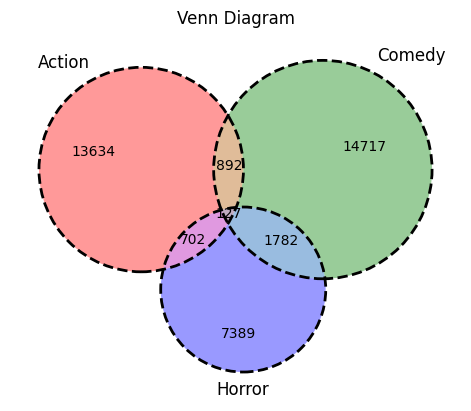

In [7]:
venn = venn3(subsets = sizes, set_labels = keep_genres)
venn_circles = venn3_circles(subsets = sizes, linestyle = '--')

plt.title('Venn Diagram')
plt.show()

In [118]:
df_data = pd.read_csv('movies-all-data.csv')
display(df_data['28'])

0          True
1          True
2          True
3          True
4          True
          ...  
131257    False
131258    False
131259    False
131260    False
131261    False
Name: 28, Length: 131262, dtype: bool